In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Read mnist data from the mat file
mnist_data = io.loadmat("./mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])

# Change to 60000 * 20 * 20
imgs_train = imgs_train.transpose(2, 0, 1)
imgs_test = imgs_test.transpose(2, 0, 1)

# Filter samples labeled 3, 8 and 9 in imgs_train
train_filter = np.isin(labels_train, [3, 8, 9])
imgs_train_389 = imgs_train[train_filter]
labels_train_389 = labels_train[train_filter]

# Filter samples labeled 3, 8 and 9 in imgs_test
test_filter = np.isin(labels_test, [3, 8, 9])
imgs_test_389 = imgs_test[test_filter]
labels_test_389 = labels_test[test_filter]

print(f"Filtered training data shape: {imgs_train_389.shape}")
print(f"Filtered training labels shape: {labels_train_389.shape}")
print(f"Filtered test data shape: {imgs_test_389.shape}")
print(f"Filtered test labels shape: {labels_test_389.shape}")

Filtered training data shape: (17931, 20, 20)
Filtered training labels shape: (17931,)
Filtered test data shape: (2993, 20, 20)
Filtered test labels shape: (2993,)


In [11]:
# Flatten the images (convert each 20x20 image into a 400-dimensional vector)
train_data = imgs_train_389.reshape(imgs_train_389.shape[0], -1)
train_labels = labels_train_389

# Compute the overall mean of the data
overall_mean = np.mean(train_data, axis=0)

# Separate the data by class and compute class-specific means
class_means = {}
class_data = {}
for label in [3, 8, 9]:
    class_data[label] = train_data[train_labels == label]
    class_means[label] = np.mean(class_data[label], axis=0)

# Compute the within-class scatter matrix Sw
Sw = np.zeros((train_data.shape[1], train_data.shape[1]))
for label in [3, 8, 9]:
    centered_data = class_data[label] - class_means[label]
    Sw += centered_data.T @ centered_data

# Compute the between-class scatter matrix Sb
Sb = np.zeros((train_data.shape[1], train_data.shape[1]))
for label in [3, 8, 9]:
    n_samples = class_data[label].shape[0]
    mean_diff = (class_means[label] - overall_mean).reshape(-1, 1)
    Sb += n_samples * (mean_diff @ mean_diff.T)

print(f"Sw shape: {Sw.shape}")
print(f"Sb shape: {Sb.shape}")

Sw shape: (400, 400)
Sb shape: (400, 400)


Projected data shape: (17931, 2)


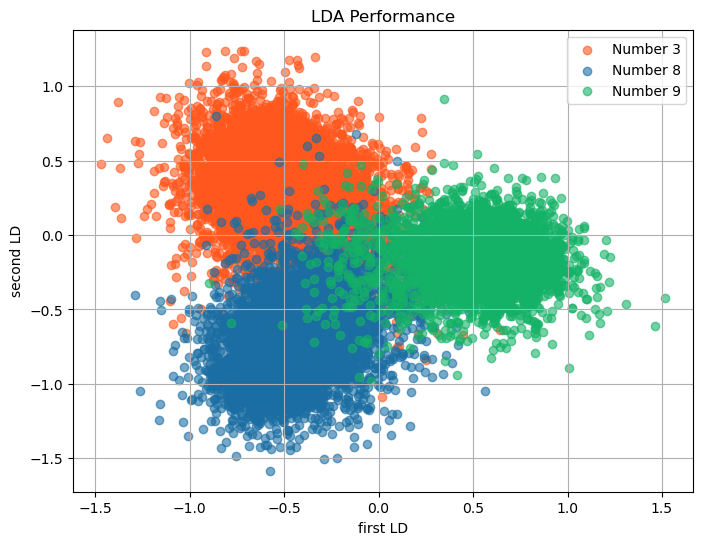

In [16]:
# Solve the generalized eigenvalue problem: Sb w = λ Sw w
eigenvalues, eigenvectors = scipy.linalg.eig(Sb, Sw)

# Sort eigenvalues and eigenvectors by descending order of eigenvalues
sorted_indices = np.argsort(-eigenvalues.real)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 2 eigenvectors (for 2D projection)
W = eigenvectors[:, :2].real

# Project the training data into the new 2D space
projected_data = train_data @ W

print(f"Projected data shape: {projected_data.shape}")

# Plot the results
plt.figure(figsize=(8, 6))
colors = ['#FF571D', '#1B6EA3', '#14B266']
labels = [3, 8, 9]
for i, label in enumerate(labels):
    plt.scatter(projected_data[train_labels == label, 0],
                projected_data[train_labels == label, 1],
                label=f"Number {label}", alpha=0.6, color=colors[i])
    
plt.title("LDA Performance")
plt.xlabel("first LD")
plt.ylabel("second LD")
plt.legend()
plt.grid()
plt.show()

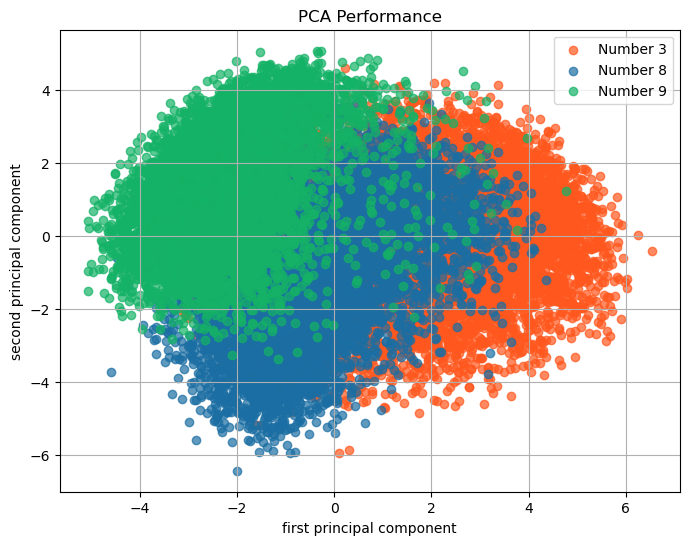

In [17]:
# Center the data by subtracting the mean
centered_data = train_data - np.mean(train_data, axis=0)

# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(centered_data, full_matrices=False)

# The top two principal components are the first two rows of Vt
top_2_pcs = Vt[:2].T

# Project the data onto the first two principal components
pca_projected_data = centered_data @ top_2_pcs

# Plot the PCA projection
plt.figure(figsize=(8, 6))
colors = ['#FF571D', '#1B6EA3', '#14B266']
labels = [3, 8, 9]
for i, label in enumerate(labels):
    plt.scatter(pca_projected_data[train_labels == label, 0],
                pca_projected_data[train_labels == label, 1],
                label=f"Number {label}", alpha=0.7, color=colors[i])
    
plt.title("PCA Performance")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.legend()
plt.grid()
plt.show()